

# 🧪 Modeling with Duke NIfTI 3D files

After downloading TCIA data and converting it to niftii files, Or downloading minimal croped niftii version from zendoo, We can start modeling on Duke data.
```
Author: Itamar Barnea
Date: 2025-04-01
Version: 1.0
Description: Module for using ML/DL on Duke niftii data
```

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import struct
import os

# Path setup

In [37]:
my_computer=True
my_colab=False
use_git_samples=False

# Root Directory where the nifti data will be places
base_path = "G:\\My Drive\\breast_mri"

In [38]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/BreastDCEDL.git

    # Change to the repository directory
    os.chdir('/content/BreastDCEDL')
        
    my_colab = True    
    base_path='/content/BreastDCEDL'

In [39]:
# setup directories of niftii data of I-SPY1, I-SPY2 and duke
    
nifti_path= {'spy2':os.path.join(base_path,"SPY2","vis1","dce"),
                        'spy1':os.path.join(base_path,"SPY1","vis1","dce"),
                        'duke':os.path.join(base_path,"DUKE","dce")}

mask_path={'spy2':os.path.join(base_path,"SPY2","vis1","mask"),
                    'spy1':os.path.join(base_path,"SPY1","vis1","mask"),
                    'duke':os.path.join(base_path,"DUKE","mask")}

if use_git_samples:
    # use for data_samples
    if use_git_samples:
        nifti_path= {'spy2':os.path.join(base_path,"SPY2","data_samples","dce"),
                            'spy1':os.path.join(base_path,"SPY1","data_samples","dce"),
                            'duke':os.path.join(base_path,"DUKE","data_samples","dce")}

        mask_path={'spy2':os.path.join(base_path,"SPY2","data_samples","mask"),
                        'spy1':os.path.join(base_path,"SPY1","data_samples","mask"),
                        'duke':os.path.join(base_path,"DUKE","data_samples")}
        

In [40]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../', 'utils')))

import data_utils as ds

ds.setup_paths(base_path, nifti_path, mask_path)

NIfTI roots : {'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\dce', 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\dce', 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\dce'}
Mask  roots : {'spy2': 'G:\\My Drive\\breast_mri\\SPY2\\vis1\\mask', 'spy1': 'G:\\My Drive\\breast_mri\\SPY1\\vis1\\mask', 'duke': 'G:\\My Drive\\breast_mri\\DUKE\\mask'}


In [72]:
df = pd.read_csv('../BreastDCEDL_metadata.csv')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2070 entries, 0 to 2069
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             2070 non-null   object 
 1   pCR             1452 non-null   float64
 2   n_xy            2070 non-null   float64
 3   n_z             2070 non-null   float64
 4   n_times         2070 non-null   float64
 5   pre             2070 non-null   float64
 6   post_early      2070 non-null   float64
 7   post_late       2070 non-null   float64
 8   slice_thick     2070 non-null   float64
 9   xy_spacing      2070 non-null   float64
 10  mask_start      2070 non-null   float64
 11  mask_end        2070 non-null   float64
 12  sraw            2070 non-null   float64
 13  eraw            2070 non-null   float64
 14  scol            2070 non-null   float64
 15  ecol            2070 non-null   float64
 16  tum_vol         1456 non-null   float64
 17  age             2070 non-null   f

# Visualize niftii and tumor bounding box

In [74]:
df.head(2)

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
0  ACRIN-6698-102212  0.0  256.0  80.0      8.0  0.0         2.0        6.0   
1  ACRIN-6698-103939  0.0  256.0  64.0      7.0  0.0         2.0        5.0   

   slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
0          2.0      0.6055  ...         1.0         0.0  0.0   0.0   
1          2.5      0.5859  ...         1.0         0.0  1.0   0.0   

   HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
0       TripleNeg        1.0      0.0           0.0     spy2   1.0  
1    HRposHER2neg        0.0      0.0           1.0     spy2   0.0  

[2 rows x 29 columns]

In [75]:
df[df.pid=='ISPY1_1230']

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
1062  ISPY1_1230  0.0  512.0  54.0      3.0  0.0         1.0        2.0   

      slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
1062     2.592592    0.390625  ...         0.0         1.0  1.0   0.0   

      HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
1062    HRposHER2neg        0.0      0.0           1.0     spy1   0.0  

[1 rows x 29 columns]

In [76]:

r=df.iloc[1062]
pid=r['pid']
print(pid, r['post_late'])
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=int(r['post_late'])) # last acqisition
print(a0.shape,a1.shape,a2.shape)

ISPY1_1230 2.0
(54, 512, 512) (54, 512, 512) (54, 512, 512)


In [77]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(32, 52, 172, 350, 102, 302, (54, 512, 512))

In [68]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm,sraw:eraw,scol:ecol]=1
m.shape

(54, 512, 512)

In [69]:
def to_rgb(im0,im1,im2):
    im = ds.minmax(np.stack([im0,im1,im2],axis=len(im0.shape)))
    return im

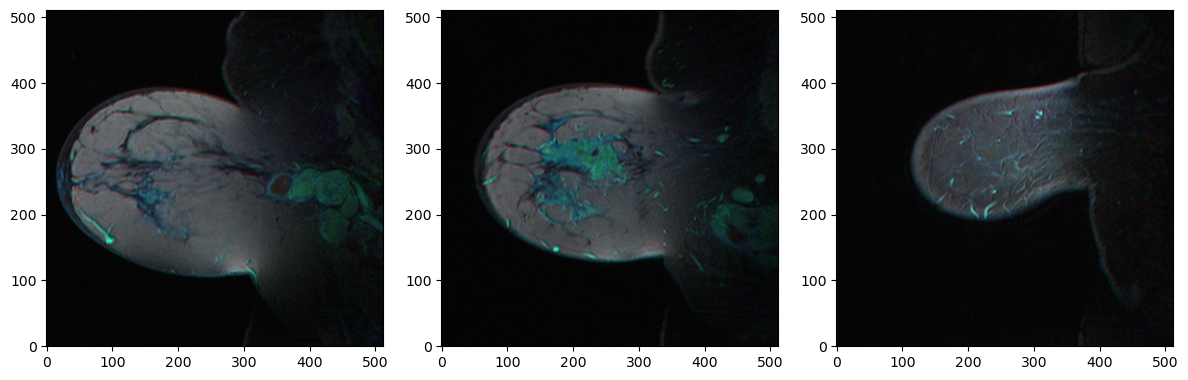

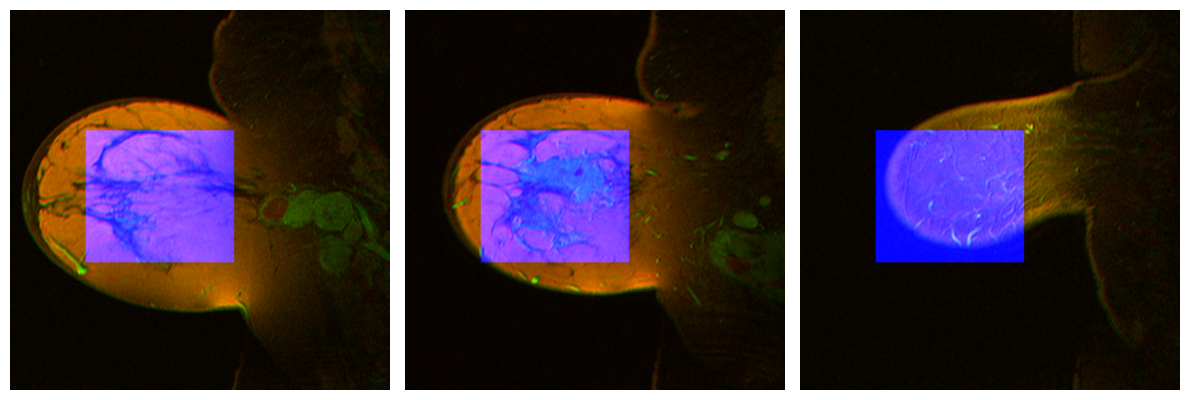

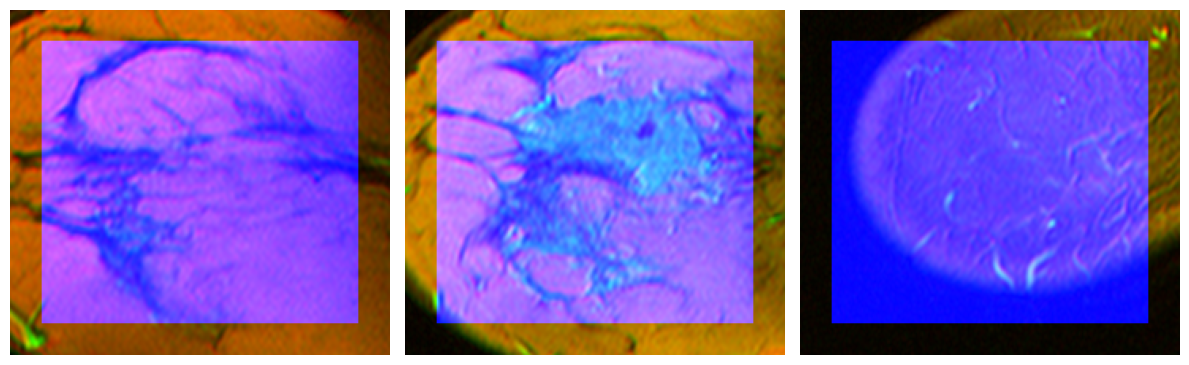

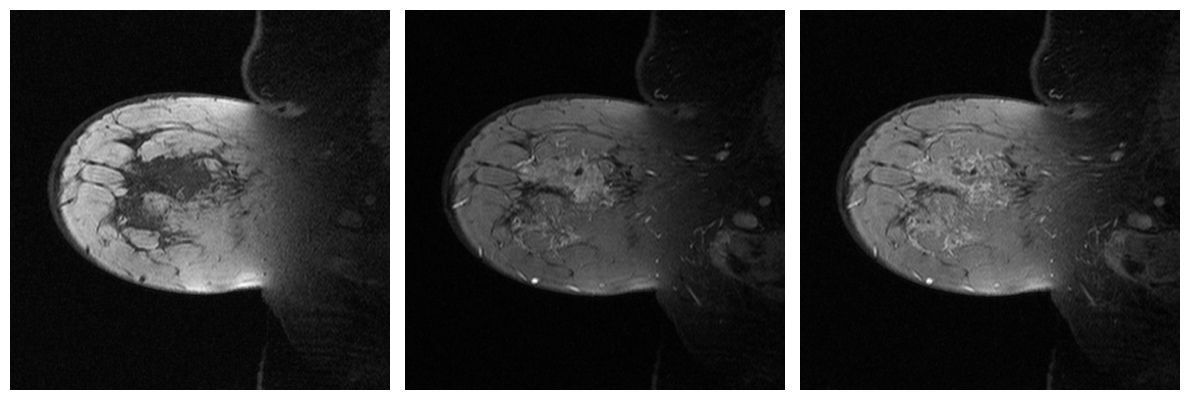

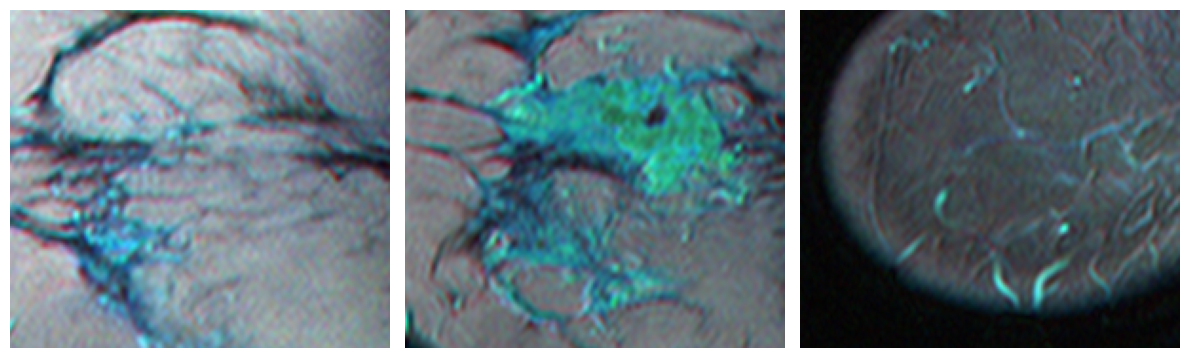

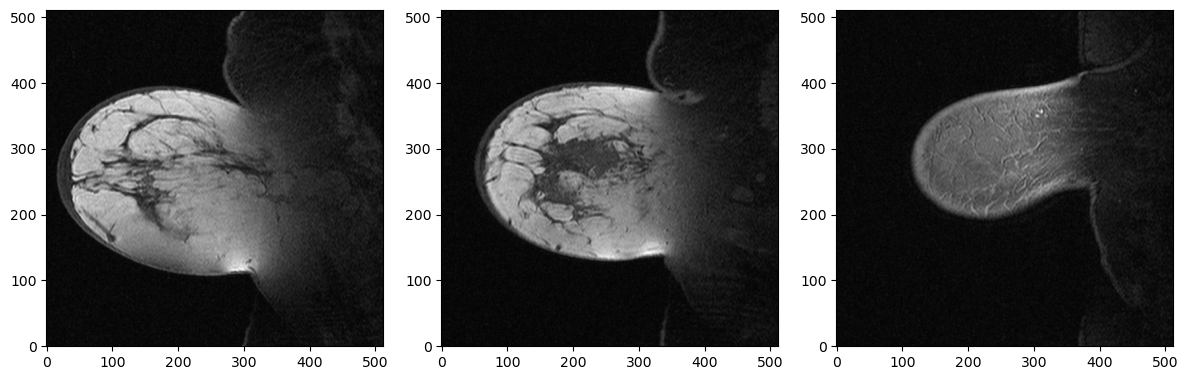

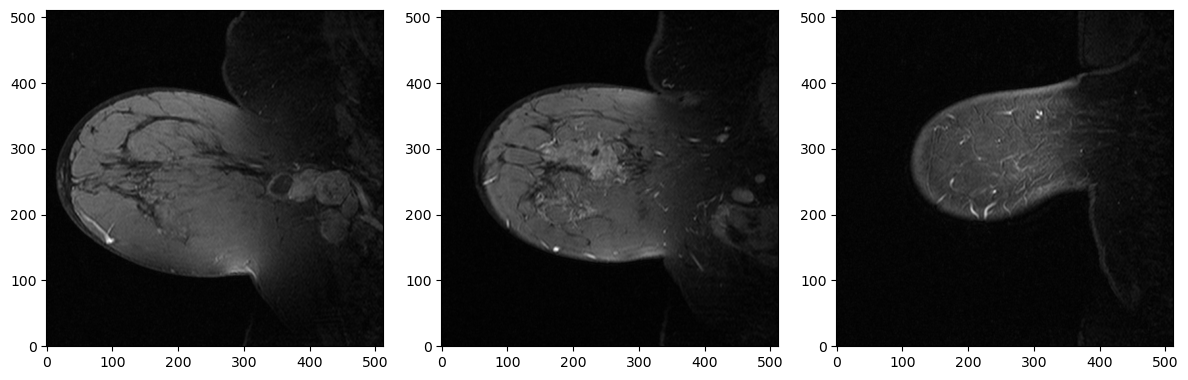

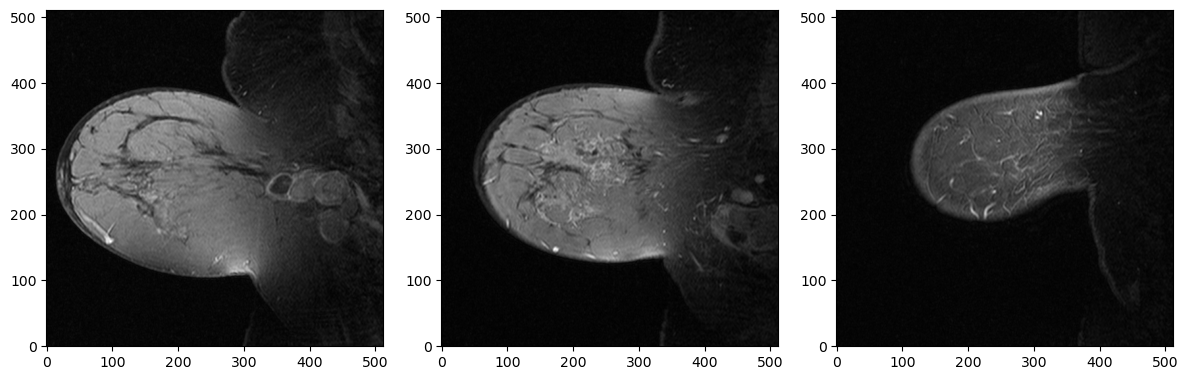

In [71]:
idx=[startm+1, (startm+endm)//2,endm-1]
ds.show_n_images([to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(a0[k]) ,
                            ds.minmax(a1[k]) ,
                            m[k]],axis=2 ) for k in idx])
ds.show_n_images([np.stack([ds.minmax(a0[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            ds.minmax(a1[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            m[k,sraw-20:eraw+20,scol-20:ecol+20]],axis=2 ) for k in idx])
ds.show_n_images([ds.minmax(a0[idx[1]]), 
                                ds.minmax(a1[idx[1]]), 
                                             ds.minmax(a2[idx[1]])]) 

ds.show_n_images([to_rgb(a0[k,sraw:eraw,scol:ecol],
                            a1[k,sraw:eraw,scol:ecol],
                            a2[k,sraw:eraw,scol:ecol])  for k in idx])
ds.show_n_images([a0[k] for k in idx], axis_off=False)
ds.show_n_images([a1[k] for k in idx], axis_off=False)
ds.show_n_images([a2[k] for k in idx], axis_off=False)

In [62]:

r=df.iloc[1]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['n_times']-1) # last acqisition

ACRIN-6698-103939


In [63]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(22, 46, 112, 183, 108, 181, (64, 256, 256))

In [ ]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm,sraw:eraw,scol:ecol]=1
m.shape

In [ ]:
idx=[startm+1, (startm+endm)//2,endm-1]
ds.show_n_images([ds.to_rgb(a0[k],a1[k],a2[k]) for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(a0[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            ds.minmax(a1[k,sraw-20:eraw+20,scol-20:ecol+20]) ,
                            m[k,sraw-20:eraw+20,scol-20:ecol+20]],axis=2 ) for k in idx])

ds.show_n_images([ds.to_rgb(a0[k,sraw:eraw,scol:ecol],
                            a1[k,sraw:eraw,scol:ecol],
                            a2[k,sraw:eraw,scol:ecol])  for k in idx])


# Code to crop 

In [9]:
import numpy as np

def crop_around_voi(array_3d, voi, slice_padding=2, output_size=256):
    """
    Crop a 3D array around a VOI with padding, then extract a centered region of output_size.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        3D array with shape (slices, rows, columns)
    voi : list or tuple
        VOI coordinates [sslc:eslc, srow:erow, scol:ecol]
    slice_padding : int
        Number of slices to pad before and after the VOI slice range
    output_size : int
        Size of the final square crop (output_size x output_size)
    
    Returns:
    --------
    numpy.ndarray
        Cropped 3D array with shape (padded_slices, output_size, output_size)
    """
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    
    # Get array dimensions
    n_slices, n_rows, n_cols = array_3d.shape
    
    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)
    
    # Calculate VOI dimensions
    voi_height = erow - srow
    voi_width = ecol - scol
    
    # Calculate VOI center
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    
    # Calculate crop bounds to create output_size x output_size image
    # that keeps the VOI centered as much as possible
    half_size = output_size // 2
    
    # Calculate initial crop bounds
    crop_srow = voi_center_row - half_size
    crop_erow = voi_center_row + half_size
    crop_scol = voi_center_col - half_size
    crop_ecol = voi_center_col + half_size
    
    # Adjust if crop goes outside image boundaries
    if crop_srow < 0:
        crop_erow -= crop_srow  # Shift down
        crop_srow = 0
    if crop_erow >= n_rows:
        shift = crop_erow - n_rows + 1
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_srow - shift)  # Shift up
    
    if crop_scol < 0:
        crop_ecol -= crop_scol  # Shift right
        crop_scol = 0
    if crop_ecol >= n_cols:
        shift = crop_ecol - n_cols + 1
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_scol - shift)  # Shift left
    
    # Ensure we have exactly output_size dimensions
    # This handles edge cases where shifting doesn't give exact size
    if crop_erow - crop_srow + 1 != output_size:
        crop_erow = crop_srow + output_size - 1
        if crop_erow >= n_rows:
            crop_erow = n_rows - 1
            crop_srow = n_rows - output_size
    
    if crop_ecol - crop_scol + 1 != output_size:
        crop_ecol = crop_scol + output_size - 1
        if crop_ecol >= n_cols:
            crop_ecol = n_cols - 1
            crop_scol = n_cols - output_size
    
    # Perform the crop
    cropped_array = array_3d[padded_sslc:padded_eslc+1, 
                             crop_srow:crop_erow+1, 
                             crop_scol:crop_ecol+1]
    
    return cropped_array, (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)

In [10]:
import numpy as np

def crop_around_voi_cords(array_3d_shape, voi, slice_padding=2, output_size=256):
    
    # Unpack VOI coordinates
    sslc, eslc = voi[0]
    srow, erow = voi[1]
    scol, ecol = voi[2]
    
    # Get array dimensions
    n_slices, n_rows, n_cols = array_3d_shape
    
    # Calculate padded slice range with bounds checking
    padded_sslc = max(0, sslc - slice_padding)
    padded_eslc = min(n_slices - 1, eslc + slice_padding)
    
    # Calculate VOI dimensions
    voi_height = erow - srow
    voi_width = ecol - scol
    
    # Calculate VOI center
    voi_center_row = (srow + erow) // 2
    voi_center_col = (scol + ecol) // 2
    
    # Calculate crop bounds to create output_size x output_size image
    # that keeps the VOI centered as much as possible
    half_size = output_size // 2
    
    # Calculate initial crop bounds
    crop_srow = voi_center_row - half_size
    crop_erow = voi_center_row + half_size
    crop_scol = voi_center_col - half_size
    crop_ecol = voi_center_col + half_size
    
    # Adjust if crop goes outside image boundaries
    if crop_srow < 0:
        crop_erow -= crop_srow  # Shift down
        crop_srow = 0
    if crop_erow >= n_rows:
        shift = crop_erow - n_rows + 1
        crop_erow = n_rows - 1
        crop_srow = max(0, crop_srow - shift)  # Shift up
    
    if crop_scol < 0:
        crop_ecol -= crop_scol  # Shift right
        crop_scol = 0
    if crop_ecol >= n_cols:
        shift = crop_ecol - n_cols + 1
        crop_ecol = n_cols - 1
        crop_scol = max(0, crop_scol - shift)  # Shift left
    
    # Ensure we have exactly output_size dimensions
    # This handles edge cases where shifting doesn't give exact size
    if crop_erow - crop_srow + 1 != output_size:
        crop_erow = crop_srow + output_size - 1
        if crop_erow >= n_rows:
            crop_erow = n_rows - 1
            crop_srow = n_rows - output_size
    
    if crop_ecol - crop_scol + 1 != output_size:
        crop_ecol = crop_scol + output_size - 1
        if crop_ecol >= n_cols:
            crop_ecol = n_cols - 1
            crop_scol = n_cols - output_size
    
    
    
    return  (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)

In [11]:
def crop_with_same_coordinates(array_3d, crop_coords):
    """
    Crop a 3D array using previously determined crop coordinates.
    
    Parameters:
    -----------
    array_3d : numpy.ndarray
        3D array to be cropped with shape (slices, rows, columns)
    crop_coords : tuple
        Coordinates from previous crop (padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol)
    
    Returns:
    --------
    numpy.ndarray
        Cropped 3D array with same dimensions as the previously cropped array
    """
    # Unpack crop coordinates
    padded_sslc, padded_eslc, crop_srow, crop_erow, crop_scol, crop_ecol = crop_coords
    
    # Check if coordinates are within bounds of the new array
    n_slices, n_rows, n_cols = array_3d.shape
    
    # Validate slice coordinates
    if padded_eslc >= n_slices:
        raise ValueError(f"Slice end coordinate {padded_eslc} exceeds array dimension {n_slices}")
    
    # Validate row coordinates
    if crop_erow >= n_rows:
        raise ValueError(f"Row end coordinate {crop_erow} exceeds array dimension {n_rows}")
    
    # Validate column coordinates
    if crop_ecol >= n_cols:
        raise ValueError(f"Column end coordinate {crop_ecol} exceeds array dimension {n_cols}")
    
    # Perform the crop using the same coordinates
    cropped_array = array_3d[padded_sslc:padded_eslc+1, 
                             crop_srow:crop_erow+1, 
                             crop_scol:crop_ecol+1]
    
    return cropped_array

# View example of cropped MRI scan

In [ ]:
Breast_MRI_001
(28, 256, 256) (28, 256, 256) (18, 256, 256)
========== shape problem Breast_MRI_001 (28, 256, 256) (18, 256, 256)
Breast_MRI_002
(18, 256, 256) (18, 256, 256) (18, 256, 256)
(3, 18, 256, 256)
=== aa max,med,shape 3253.0 255.0 (3, 18, 256, 256)
Breast_MRI_003
(17, 256, 256) (17, 256, 256) (18, 256, 256)
========== shape problem Breast_MRI_003 (17, 256, 256) (18, 256, 256)

In [12]:
df[df.pid=='Breast_MRI_001']

pid  n_xy  ER  PR  HER2  Mol_Subtype  stage_tum_s  Tumor_Grade  \
0  Breast_MRI_001   448   0   0     1            2          2.0          3.0   

   Nottingham_grade  FOVcm  ...   ecol  mask_start  mask_end    n_z n_times  \
0               2.0     15  ...  341.0        89.0     112.0  160.0     5.0   

  xy_spacing  voxel_z  pre  post_early  post_late  
0   0.803571      1.1    0           1        4.0  

[1 rows x 38 columns]

In [13]:

r=df.iloc[0]
pid=r['pid']
print(pid)
a0=ds.get_nifti_acquisition(pid, idx=0)
a1=ds.get_nifti_acquisition(pid, idx=1)
a2=ds.get_nifti_acquisition(pid, idx=r['n_times']-1) # last acqisition

Breast_MRI_001


In [14]:
startm=int(r['mask_start'])
endm=int(r['mask_end'])
        
sraw=int(r['sraw'])
eraw=int(r['eraw'])

scol=int(r['scol'])
ecol=int(r['ecol'])
startm,endm,sraw,eraw,scol,ecol,a0.shape

(89, 112, 234, 271, 308, 341, (160, 448, 448))

In [15]:
# create binary mask from bounding box
m = np.zeros(a0.shape)
m[startm:endm+1,sraw:eraw,scol:ecol]=1
m.shape

(160, 448, 448)

In [108]:
# Example usage:
# Assuming array_3d has shape (120, 458, 458) and voi is defined as:
voi = [(startm,endm),(sraw,eraw),(scol,ecol)]  # [sslc:eslc, srow:erow, scol:ecol]

# Perform the crop
cropped_volume, crop_coords = crop_around_voi(a0, voi, slice_padding=2, output_size=256)

# Print results
print(f"Original shape: {a0.shape}")
print(f"Cropped shape: {cropped_volume.shape}")
print(f"Crop coordinates: {crop_coords}")
cropped_volume.shape,voi,voi[0][0],voi[0][1],crop_coords[0],crop_coords[1]

Original shape: (148, 512, 512)
Cropped shape: (14, 256, 256)
Crop coordinates: (37, 50, 223, 478, 255, 510)


((14, 256, 256), [(39, 48), (331, 371), (408, 434)], 39, 48, 37, 50)

In [109]:
ca0=cropped_volume

In [110]:
ca1 = crop_with_same_coordinates(a1, crop_coords)
ca2 = crop_with_same_coordinates(a1, crop_coords)
cm = crop_with_same_coordinates(m, crop_coords)
ca1.shape

(14, 256, 256)

[40, 43, 47] [3, 6, 10]


<Figure size 640x480 with 0 Axes>

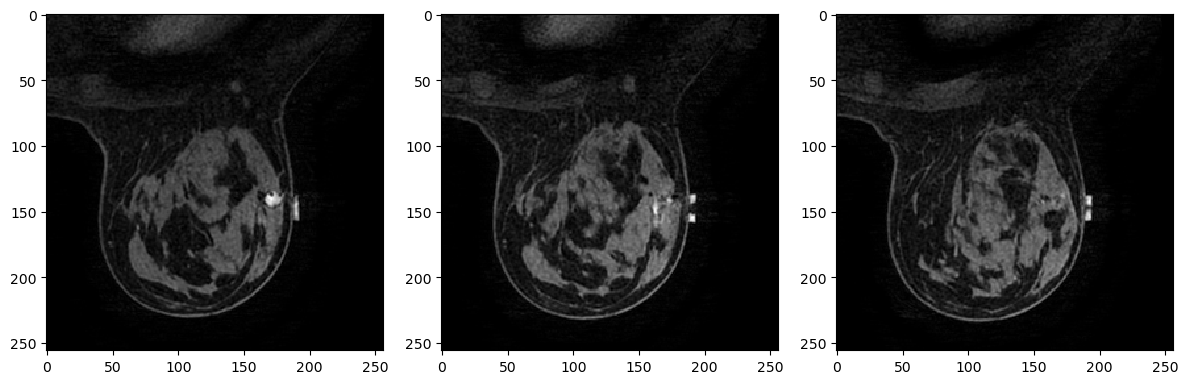

<Figure size 640x480 with 0 Axes>

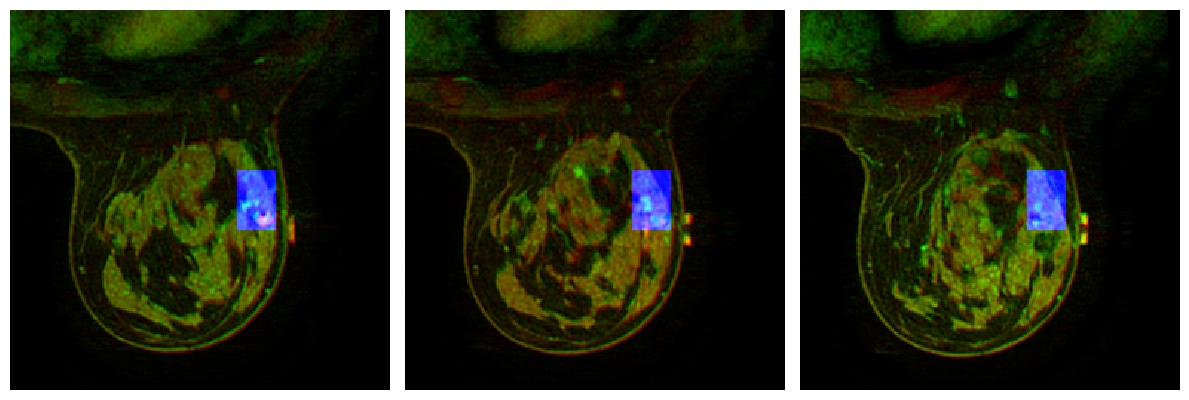

In [111]:
idx=[voi[0][0]+1,(voi[0][0]+voi[0][1])//2, voi[0][1]-1]
print(idx, [c-crop_coords[0] for c in idx])
ds.show_n_images([ca0[k-crop_coords[0]] for k in idx], axis_off=False)
ds.show_n_images([np.stack([ds.minmax(ca0[k-crop_coords[0]]) ,
                            ds.minmax(ca1[k-crop_coords[0]]) ,
                            cm[k-crop_coords[0]]],axis=2 ) for k in idx])




In [113]:
fpath="C:\\Users\\naomi\\Downloads\\breast_mri\\duke\\min_dce"

In [16]:
fpath="G:\\My Drive\\breast_mri\\DUKE\min_dce"

In [18]:
df_crop = df.copy()
for c in ['mask_start', 'mask_end',
       'sraw', 'eraw', 'scol', 'ecol','n_z','n_xy']:
    df_crop['org_'+c]=df_crop[c]

In [ ]:
Breast_MRI_001

In [ ]:
Breast_MRI_001
(28, 256, 256) (28, 256, 256) (18, 256, 256)
========== shape problem Breast_MRI_001 (28, 256, 256) (18, 256, 256)
Breast_MRI_002
(18, 256, 256) (18, 256, 256) (18, 256, 256)
(3, 18, 256, 256)
=== aa max,med,shape 3253.0 255.0 (3, 18, 256, 256)
Breast_MRI_003
(17, 256, 256) (17, 256, 256) (18, 256, 256)
========== shape problem Breast_MRI_003 (17, 256, 256) (18, 256, 256)
ppp=['Breast_MRI_001','Breast_MRI_002','Breast_MRI_003']

In [24]:
import nibabel as nib
def save_niftii(fname, np_img):
 
    converted_array = np.array(np_img, dtype=np.float64)
    affine = np.eye(4)
    nifti_file = nib.Nifti1Image(converted_array, affine)
    
    nib.save(nifti_file, fname)

In [28]:
dfall = pd.read_csv('../BreastDCEDL_metadata_min.csv')

In [25]:
ppp=['Breast_MRI_001','Breast_MRI_002','Breast_MRI_003']

In [30]:
dfall[dfall.pid.isin(ppp)]

pid  pCR   n_xy   n_z  n_times  pre  post_early  post_late  \
1154  Breast_MRI_001  0.0  256.0  28.0      5.0  0.0         1.0        4.0   
1155  Breast_MRI_002  0.0  256.0  18.0      4.0  0.0         1.0        3.0   
1156  Breast_MRI_003  NaN  256.0  17.0      5.0  0.0         1.0        4.0   

      slice_thick  xy_spacing  ...  race_white  race_black   HR  HER2  \
1154          1.1    0.803571  ...         0.0         1.0  0.0   1.0   
1155          1.3    0.585900  ...         0.0         1.0  0.0   0.0   
1156          2.0    0.683600  ...         1.0         0.0  1.0   0.0   

      HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  dataset  test  
1154         HER2pos        0.0      1.0           0.0     duke   0.0  
1155       TripleNeg        1.0      0.0           0.0     duke   1.0  
1156    HRposHER2neg        0.0      0.0           1.0     duke   0.0  

[3 rows x 29 columns]

In [33]:
df_crop[df_crop.pid.isin(ppp)][[c for c in dfall.columns if c in df_crop.columns]]

pid  pCR  n_xy   n_z  n_times  pre  post_early  post_late  \
0  Breast_MRI_001  0.0   256  28.0      5.0    0           1        4.0   
1  Breast_MRI_002  0.0   256  18.0      4.0    0           1        3.0   
2  Breast_MRI_003  0.0   256  17.0      5.0    0           1        4.0   

   slice_thick  xy_spacing  ...  age  menopause  race_white  race_black  HR  \
0          1.1    0.803571  ...   41        0.0           0           1   0   
1          1.3    0.585900  ...   38        0.0           0           1   0   
2          2.0    0.683600  ...   62        1.0           1           0   1   

   HER2  HR_HER2_STATUS  TripleNeg  HER2pos  HRposHER2neg  
0     1         HER2pos          0        1             0  
1     0       TripleNeg          1        0             0  
2     0    HRposHER2neg          0        0             1  

[3 rows x 26 columns]

In [35]:
    #if min_duke:

    # Iterate through DataFrame rows
    for i, row in df.iterrows():
        
        pid =  row['pid']
        #if pid != 'Breast_MRI_728': continue
        if pid not in ppp : continue
            
        print(i,row['pid'],row['mask_start'],row['mask_end'])
        
        
        startm=int(row['mask_start'])
        endm=int(row['mask_end'])
        
        sraw=int(row['sraw'])
        eraw=int(row['eraw'])

        scol=int(row['scol'])
        ecol=int(row['ecol'])

        a0=ds.get_nifti_acquisition(pid, idx=0)
        
        if a0 is not None:
            if row['n_z'] is not None:
                z=int(row['n_z'])
                assert(a0.shape[0]==z)
            else:
                df_crop.at[i,'org_n_z']=a0.shape[0]
                print('correct n_z of ',pid,' to ',a0.shape[0])
        else:
            continue
            
        w=int(row['n_xy'])
        
        
        assert(a0.shape[1]==w)
        assert(a0.shape[2]==w)
        assert(int(row['post_late'])==int(row['n_times']-1))
        
        print(i, '---',pid,a0.shape)
        voi = [(startm,endm),(sraw,eraw),(scol,ecol)] 
        crop_coords = crop_around_voi_cords(a0.shape, voi, slice_padding=1, output_size=256)
        print('===========  crop cords',crop_coords, pid, '=== ',a0.shape)
        
        #(41, 140, 161, 416, 255, 510)
        df_crop.at[i, 'crop_mask_start']=crop_coords[0]
        df_crop.at[i, 'crop_mask_end']=crop_coords[1]
        df_crop.at[i, 'crop_sraw']=crop_coords[2]
        df_crop.at[i, 'crop_eraw']=crop_coords[3]
        df_crop.at[i, 'crop_scol']=crop_coords[4]
        df_crop.at[i, 'crop_ecol']=crop_coords[5]
        r=row
        i1 = int(row['post_early'])
        i2 = int(row['post_late'])
        i0=0
        a1=ds.get_nifti_acquisition(pid, idx=i1)
        a2=ds.get_nifti_acquisition(pid, idx=i2)
        print('all shapws: ', a0.shape, a1.shape,a2.shape)
        ca0 = crop_with_same_coordinates(a0, crop_coords)
        ca1 = crop_with_same_coordinates(a1, crop_coords)
        ca2 = crop_with_same_coordinates(a2, crop_coords)
        c = [ca1,ca1,ca2]
        print('all shapws after: ', ca0.shape, ca1.shape,ca2.shape)

        
        fn = pid+'_duke_aqc_0.nii.gz'
        save_niftii(os.path.join(fpath, fn),ca0)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_duke_aqc_1.nii.gz'
        save_niftii(os.path.join(fpath, fn),ca1)
        print('saving:',os.path.join(fpath, fn))
        
        fn = pid+'_duke_aqc_'+str(int(i2))+'.nii.gz'
        save_niftii(os.path.join(fpath, fn),ca2)
        print('saving:',os.path.join(fpath, fn))
        
        print('ser:', i0,i1,i2)  
        # Calculate New variables
        df_crop.at[i,'mask_start'] = startm-crop_coords[0]
        df_crop.at[i,'mask_end'] = endm-crop_coords[0]
        df_crop.at[i,'sraw'] = sraw-crop_coords[2]
        df_crop.at[i,'eraw'] = eraw-crop_coords[2]
        df_crop.at[i,'scol'] = scol-crop_coords[4]
        df_crop.at[i,'ecol'] = ecol-crop_coords[4]
        
        assert(df.at[i,'mask_start']-crop_coords[0]>=0) 
        assert(df.at[i,'mask_end']-crop_coords[0]>=0) 
        assert(df.at[i,'sraw']-crop_coords[2]>=0) 
        assert( df.at[i,'eraw']-crop_coords[2]>=0) 
        assert(df.at[i,'scol']-crop_coords[4]>=0) 
        assert(df.at[i,'ecol']-crop_coords[4]>=0) 
        
        df_crop.at[i,'n_xy'] = 256
        df_crop.at[i,'n_z'] = ca0.shape[0]
        
        

0 Breast_MRI_001 89.0 112.0
0 --- Breast_MRI_001 (160, 448, 448)
===========  crop cords (88, 113, 124, 379, 191, 446) Breast_MRI_001 ===  (160, 448, 448)
all shapws:  (160, 448, 448) (160, 448, 448) (160, 448, 448)
all shapws after:  (26, 256, 256) (26, 256, 256) (26, 256, 256)
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_001_duke_aqc_0.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_001_duke_aqc_1.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_001_duke_aqc_4.nii.gz
ser: 0 1 4
1 Breast_MRI_002 59.0 72.0
1 --- Breast_MRI_002 (142, 512, 512)
===========  crop cords (58, 73, 144, 399, 0, 255) Breast_MRI_002 ===  (142, 512, 512)
all shapws:  (142, 512, 512) (142, 512, 512) (142, 512, 512)
all shapws after:  (16, 256, 256) (16, 256, 256) (16, 256, 256)
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_002_duke_aqc_0.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Breast_MRI_002_duke_aqc_1.nii.gz
saving: G:\My Drive\breast_mri\DUKE\min_dce\Brea

Breast_MRI_801 duke
no nifti files
==== No mask No BoundingBox


<Figure size 640x480 with 0 Axes>

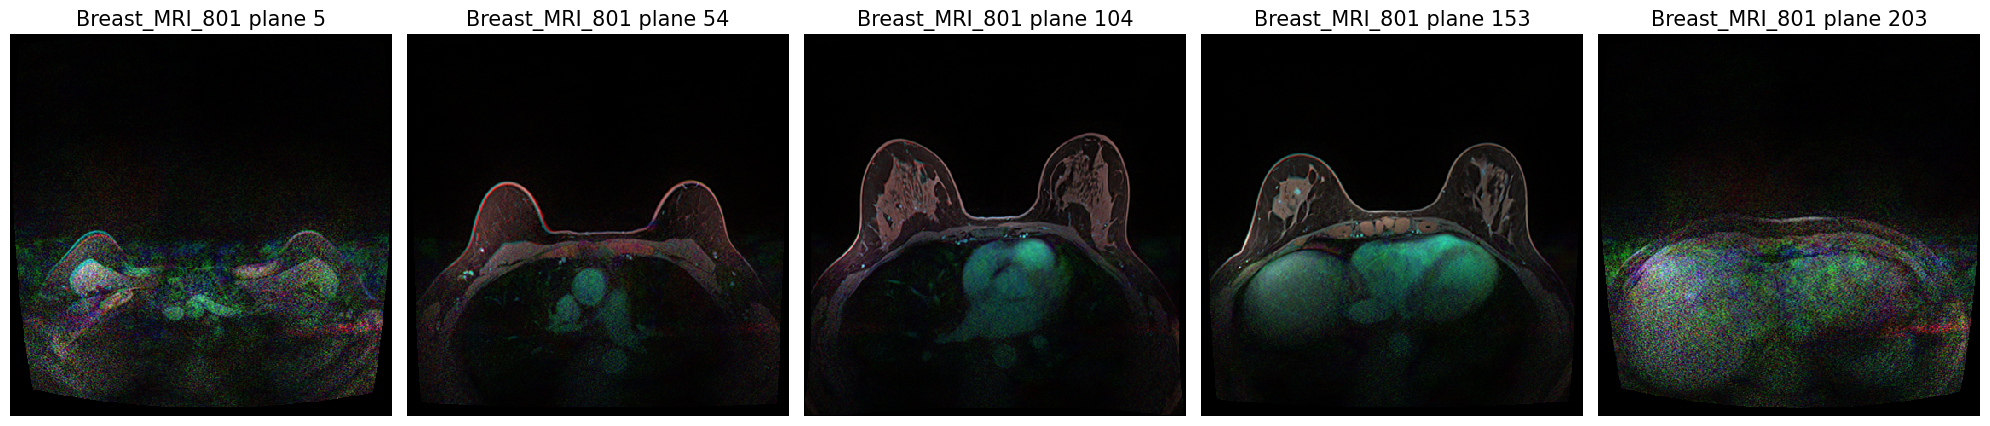

In [49]:
ds.show_pid('Breast_MRI_801',[0,1,2])

In [36]:
ca0.shape

(32, 256, 256)

In [64]:
df_crop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 68 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pid                       918 non-null    object 
 1   Slice_Thickness           918 non-null    int64  
 2   Rows                      918 non-null    int64  
 3   Columns                   918 non-null    int64  
 4   FOVcm                     918 non-null    int64  
 5   Date_of_Birth_(Days)      918 non-null    int64  
 6   Menopause_(at_diagnosis)  918 non-null    int64  
 7   Race_and_Ethnicity        918 non-null    int64  
 8   ER                        918 non-null    int64  
 9   PR                        918 non-null    int64  
 10  HER2                      918 non-null    int64  
 11  Mol_Subtype               918 non-null    int64  
 12  stage_tum_s               914 non-null    float64
 13  Tumor_Grade               905 non-null    float64
 14  Nottingham

In [68]:
df_crop.to_csv('BrestDCEDL_duke_cropped.csv', index = False)
df_crop.shape

(918, 68)

922 paitents, 6 had missing data, final 986